[View in Colaboratory](https://colab.research.google.com/github/christopher-ell/Deep_Learning_Begin/blob/master/OPT_TransferLearning_AntBees.ipynb)

Official Pytorch Tutorials - Transfer Learning

Source: http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [0]:
#!pip install torch
#!pip install torchvision

In [0]:
#!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
#!unzip hymenoptera_data.zip

Two Major Transfer Learning Scenarios

1) Finetuning The Covnet: Instead of randomised initiation, the network is initialised with a pretrained network, like the one trained on imagenet 1000 dataset. 

2) ConvNet as Fixed Feature Extractor: Freeze the weights for the whole network except the final fully connected layer. The final layer is replaced by one with random weights and is the only layer trained

**1. Dependencies**

In [0]:
# Dependencies
import time
import os
import copy
import matplotlib.pyplot as plt
from __future__ import print_function, division
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

plt.ion() # interactive mode

**2. Load Data**

In [0]:
# Data auguementation and normalisation for training
# Just normalisation for validation

## Tansforms are stored in a dictionary 
## Transforms have a number of purposes here, including to:
##    i) Make the images compatible with Pytorch i.e. ToTensor()
##    ii) Allow the images to be run more efficiently i.e. Normalise()
##    iii) Make image size compatible with NN by making all images the same size
##         i.e. RandomResizedCrop(224)
##    iv) Prevent overfitting / create new data by randomly making change to the 
##        while keeping it's subject the same i.e. RandomHorizontalFlip()
## Compose groups a set of transforms together
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
## For validation some of the above transforms are unnecessary. transforms which
## put the image in Pytorch format, normalise it and make images the same size 
## are still important. But randomisaton is gone in the resize and crop and image
## flip is gone because you do not require more data
    'val':transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

## Name of dataset beng used
data_dir = 'hymenoptera_data'
## import the training and validation set of images by looping through both entries
## in the dictionary. 
## Create a new dictionary of the datasets and transforms for each set of training
## and validation images
## use ImageFolder from the datasets library to import a foler of images in each
## of the categories
image_datasets = {x:datasets.ImageFolder(os.path.join(data_dir, x), 
                                        data_transforms[x])
                 for x in ['train', 'val']}

## Create dictionary of training and validation dataloaders by looping through 
## the image datasets dictionary. 
## Apply batch_size of 4, meaning in each training loop 4 images at a time will
## be run through the loop
## Shuffle: reshuffles data at every epoch
## num_workers: Number of subprocesses running at a time.
dataloaders = {x:torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                            shuffle=True, num_workers=4)
              for x in ['train', 'val']}

## Create dictionary storing the size of each training and validation set
dataset_sizes = {x:len(image_datasets[x]) for x in ['train', 'val']}

## Create list of class names to look up when visualising results.
class_names = image_datasets['train'].classes

## Create function that returns "cuda:0" if it is being run with a GPU and cpu
## if it is not being run on a GPU but instead a CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [29]:
print(class_names)

['ants', 'bees']


**3. Visualise a Few Images**

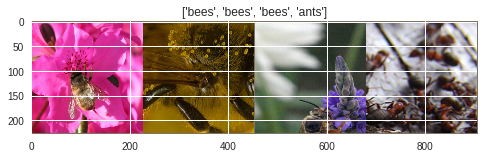

In [35]:
def imshow(inp, title=None):
  """imshow for Tensor."""
  ## inp.numpy converts the image (inp) into a numpy array
  ## transpose changes the dimensions of the array so all images have same 
  ## dimensions
  inp = inp.numpy().transpose((1, 2, 0))
  ## Set mean and standard deviation of images, so they are consistent
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  ## Sets the maximum value in each array
  inp = np.clip(inp, 0, 1)
  ## Show the image
  plt.imshow(inp)
  ## Show the title of the images if it exists
  if title is not None:
    plt.title(title)
  plt.pause(0.001) # pause a bit so plots are updated
  
  
# Get a batch of training data
## next() retrieves the next item in the iterator
## iter() without a second object must be a collection object 
## Takes one batch of pictures and labels (0 or 1)
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
## torchvision.utils.make_grid() creates a grid of images from the tensor inputs
out = torchvision.utils.make_grid(inputs)

## Run above function to standardise and show all images in batch
imshow(out, title=[class_names[x] for x in classes])

**4. Training The Model**

In [0]:
def train_model(model, criterion, optimiser, scheduler, num_epochs=25):  
  ## Record time that training starts
  since = time.time()
  
  ## Set initial best model version to provided model
  best_model_wts = copy.deepcopy(model.state_dict())
  ## Set best accuracy to 0
  best_acc = 0.0
  
  ## Output current epoch of total epochs and ten dashes underneath
  for epoch in range(num_epochs):
    ## Current epoch over total epochs
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    ## Ten dashes
    print('-'*10)
    
    # Each epoch has a training and validation phase
    ## Loop through first a training phase than a validation phase
    for phase in ['train', 'val']:
      ## If the program is in the training phase
      if phase == 'train':
        ## Sets up how the learning rate will be adjusted over time
        scheduler.step()
        ## Puts the model in training mode
        model.train() # Set model to training mode 
      else:
        ## Puts the model into evaluation mode
        model.eval() # Set model to evaluation mode
        
      ## Initialise values of running_loss and running_corrects
      running_loss = 0.0
      running_corrects = 0
      
      # Iterate over data
      ## Iterate of training/validation data batches
      for inputs, labels in dataloaders[phase]:
        ## Set the image type and label to cuda:10 or CPU processing 
        ## based on whether or not the computer has a GPU
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        ## zero gradients as they are cumulative
        optimiser.zero_grad()
        
        # forward
        # track history if only in train
        ## If you are training the model do the below
        with torch.set_grad_enabled(phase == 'train'):
          ## Run the model to get outputs
          outputs = model(inputs)
          ## Take the max output for each example as the prediction
          _, preds = torch.max(outputs, 1)
          ## Run the predictions against the actual results with the loss 
          ## function to get the loss
          loss = criterion(outputs, labels)
          
          # backwards + optimise only if in training phase
          ## If program is in training phase run backpropagation and 
          ## update weights using specified update algorithm
          if phase == 'train':
            loss.backward()
            optimiser.step()
          
        # Statistics
        ## Loss.item() gives loss fo each batch and input.size(0) gives number of
        ## items for each batch. So it is total loss for every image/input
        running_loss += loss.item() * inputs.size(0)
        #print("loss.item(): ", loss.item(), " inputs.size(0): ", inputs.size(0))
        ## Adds all instances where the predicted label was equal to the label
        running_corrects += torch.sum(preds==labels.data)
      
      
      ## Running_loss is total loss from epoch and dataset_size is size of total
      ## dataset in epoch. So this gives average loss per input in epoch
      epoch_loss = running_loss / dataset_sizes[phase]
      #print("running_loss: ", running_loss, " dataset_sizes[phase]: ", dataset_sizes[phase])
      ## running_corrects.double()  gives total number of correct answers as a double type
      ## dataset_sizes[phase] gives total size of dataset
      ## epoch_acc gives otal accuracy of predictions in epoch (correct/total)
      epoch_acc = running_corrects.double() / dataset_sizes[phase]
      
      ## Outputs in formatted way whether validation ot training result, the loss
      ## per input in epoch and the accuracy in the epoch
      print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        phase, epoch_loss, epoch_acc))
      
      # Deep copy the model
      ## If the accuracy (validation) of the current model is better than the 
      ## accuracy (validation) of the best model so far copy the current model 
      ## into the best model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        
    print()
    
  ## Calculate how long since the model started running  
  time_elapsed = time.time() - since
  ## Print out how long since the model started running by minutes and seconds
  print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
  ## Print best models accuracy
  print('Best val Acc: {:4f}'.format(best_acc)) 
  
  # Load best model weights
  model.load_state_dict(best_model_wts)
  return model

**5. Visualising The Model Predictions**

In [0]:
def visualise_model(model, num_images=6):
  ## Function to put model into training mode
  was_training=model.training
  ## Put model into evaluation mode
  model.eval()
  ## Initialise image_sso_far to 0
  images_so_far = 0
  ## Plot figures
  fig = plt.figure()
  
  ## ???? ##
  with torch.no_grad():
    
    for i, (inputs, labels) in enumerate(dataloaders['val']):
      inputs = inputs.to(device)
      labels = labels.to(device)
      
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      
      for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images//2, 2, images_so_far)
        ax.axis('off')
        ax.set_title('predicted: {}'.format(class_names[preds[j]]))
        imshow(inputs.cpu().data[j])
        
        if images_so_far == num_images:
          model.train(mode=was_training)
          return
    model.train(mode=was_training)

**6. Finetuning The CovNet**

In [0]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_fit.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being rferenced
optimiser_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimiser_ft, step_size=7, gamma=0.1)

**7. Train and Evaluate**

In [21]:
model_ft = train_model(model_ft, criterion, optimiser_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6047 Acc: 0.6885
val Loss: 0.2134 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.5307 Acc: 0.8238
val Loss: 0.2352 Acc: 0.8954

Epoch 2/24
----------
train Loss: 0.5882 Acc: 0.7992
val Loss: 0.1870 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.4174 Acc: 0.8197
val Loss: 0.2864 Acc: 0.8824

Epoch 4/24
----------
train Loss: 0.4587 Acc: 0.8279
val Loss: 0.2100 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.4972 Acc: 0.7951
val Loss: 0.2344 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.4165 Acc: 0.8484
val Loss: 0.3507 Acc: 0.8758

Epoch 7/24
----------
train Loss: 0.5136 Acc: 0.8361
val Loss: 0.2489 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.2888 Acc: 0.8975
val Loss: 0.1762 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.2974 Acc: 0.8402
val Loss: 0.1932 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3500 Acc: 0.8689
val Loss: 0.2015 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3993 Acc: 0.8279
val Loss: 0.2026 Acc: 0.9346

Ep

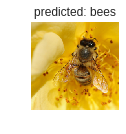

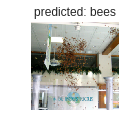

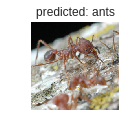

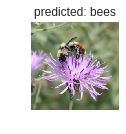

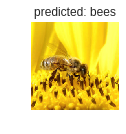

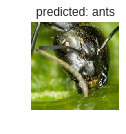

Exception NameError: "global name 'FileNotFoundError' is not defined" in <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5b48a56cd0>> ignored


In [24]:
visualise_model(model_ft)

**8. CovNet as Fixed Feature Extractor**

In [0]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
  param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimised as
# opposed to before.
optimiser_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimiser_conv, step_size=7, gamma=0.1)

**9. Train and Evaluate**

In [28]:
model_conv = train_model(model_conv, criterion, optimiser_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5543 Acc: 0.6926
val Loss: 0.2531 Acc: 0.8889

Epoch 1/24
----------
train Loss: 0.5639 Acc: 0.7582
val Loss: 0.2076 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.5647 Acc: 0.7746
val Loss: 0.1787 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.4839 Acc: 0.7869
val Loss: 0.4880 Acc: 0.8235

Epoch 4/24
----------
train Loss: 0.5039 Acc: 0.7787
val Loss: 0.4461 Acc: 0.8301

Epoch 5/24
----------
train Loss: 0.3863 Acc: 0.8525
val Loss: 0.2151 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.3476 Acc: 0.8689
val Loss: 0.1918 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.2648 Acc: 0.8975
val Loss: 0.1703 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.2798 Acc: 0.8811
val Loss: 0.2044 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3540 Acc: 0.8402
val Loss: 0.1855 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3372 Acc: 0.8484
val Loss: 0.1744 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3662 Acc: 0.8525
val Loss: 0.1769 Acc: 0.9608

Ep

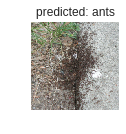

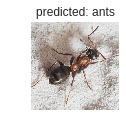

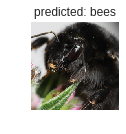

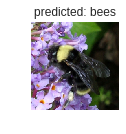

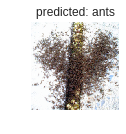

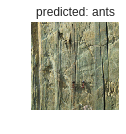

Exception NameError: "global name 'FileNotFoundError' is not defined" in <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5b439f8390>> ignored


In [38]:
visualise_model(model_conv)

plt.ioff()
plt.show()

In [0]:
model_conv = train_model(model_conv, criterion, optimiser_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
running_loss:  96.650367843  dataset_sizes[phase]:  244
train Loss: 0.3961 Acc: 0.8115
running_loss:  28.6148005587  dataset_sizes[phase]:  153
val Loss: 0.1870 Acc: 0.9412

Epoch 1/24
----------
running_loss:  70.373886425  dataset_sizes[phase]:  244
train Loss: 0.2884 Acc: 0.8566
running_loss:  30.8211285099  dataset_sizes[phase]:  153
val Loss: 0.2014 Acc: 0.9477

Epoch 2/24
----------
running_loss:  66.1615818869  dataset_sizes[phase]:  244
train Loss: 0.2712 Acc: 0.8689
running_loss:  30.7248542852  dataset_sizes[phase]:  153
val Loss: 0.2008 Acc: 0.9412

Epoch 3/24
----------
running_loss:  88.5305076968  dataset_sizes[phase]:  244
train Loss: 0.3628 Acc: 0.8320
running_loss:  33.5195422182  dataset_sizes[phase]:  153
val Loss: 0.2191 Acc: 0.9412

Epoch 4/24
----------
running_loss:  85.8155038878  dataset_sizes[phase]:  244
train Loss: 0.3517 Acc: 0.8443
running_loss:  27.8343698131  dataset_sizes[phase]:  153
val Loss: 0.1819 Acc: 0.9477

Epoch 5/24
------